C:\Users\laan\AppData\Local\Temp\ipykernel_85588\4269599776.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


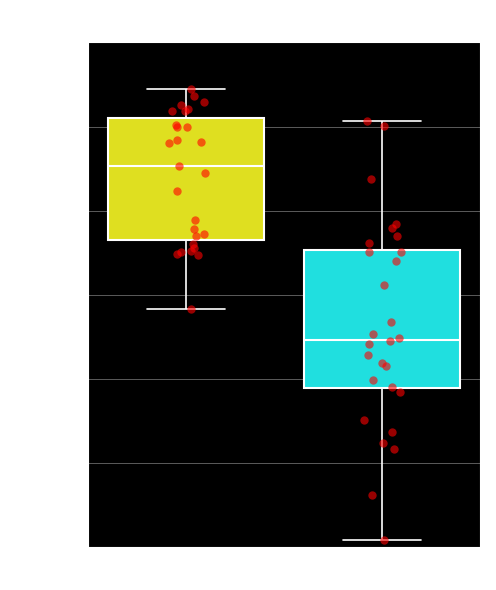

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set dark background style
plt.style.use('dark_background')
sns.set_style('dark')

# --- Load CSV ---
file_path = 'W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Maximum projections\\ROIs for analysis\\output\\'  
df = pd.read_csv(file_path + 'spacing_results.csv')

# --- Categorize rows as singlets or doublets ---
def categorize(filename):
    if 'doublets' in filename.lower():
        return 'Doublets'
    elif 'singlets' in filename.lower():
        return 'Singlets'
    else:
        return 'Unknown'

df['Type'] = df['Filename'].apply(categorize)

# Filter only recognized types
df = df[df['Type'].isin(['Doublets', 'Singlets'])]

# --- Convert spacing to non-expanded values ---
expansion_factor = 4.23  # Sample expansion factor
df['FFT_Spacing_um'] = df['FFT_Spacing_um'] / expansion_factor

# --- Custom colors ---
palette = {'Doublets': 'yellow', 'Singlets': 'cyan'}

# Common boxplot styles
boxprops = dict(edgecolor='white', linewidth=1.5)
whiskerprops = dict(color='white', linewidth=1.2)
capprops = dict(color='white', linewidth=1.2)
medianprops = dict(color='white', linewidth=1.5)

# --- Create plot ---
plt.figure(figsize=(5, 6))

sns.boxplot(
    data=df,
    x='Type',
    y='FFT_Spacing_um',
    palette=palette,
    showfliers=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    linewidth=1.5
)

sns.stripplot(
    data=df,
    x='Type',
    y='FFT_Spacing_um',
    dodge=True,
    color='red',
    alpha=0.6,
    edgecolor='black',
    size=6,
    jitter=True
)

# Set inner plot background to black
plt.gca().set_facecolor('black')
# Axis labels and title
plt.title('Cilia spacing between rows', fontsize=24, color='white')
plt.ylabel('Spacing (µm)', fontsize=22, color='white')
plt.xlabel(None)

# Ticks and grid
plt.xticks(color='white', size=18)
plt.yticks(color='white', size=18)
plt.ylim(1.4, 2.6)
plt.grid(True, axis='y', color='white', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(file_path, 'fft_spacing_singlets_vs_doublets.svg'), format='svg')
plt.savefig(os.path.join(file_path, 'fft_spacing_singlets_vs_doublets.png'), dpi=300)
plt.show()
plt.close()


In [2]:
import numpy as np

for group in ['Doublets', 'Singlets']:
    group_df = df[df['Type'] == group]
    mean_val = group_df['FFT_Spacing_um'].mean()
    std_val = group_df['FFT_Spacing_um'].std()
    n = group_df['FFT_Spacing_um'].count()
    print(f"{group}: mean = {mean_val:.3f} µm, std = {std_val:.3f} µm, n = {n}")

Doublets: mean = 2.279 µm, std = 0.156 µm, n = 27
Singlets: mean = 1.928 µm, std = 0.248 µm, n = 28


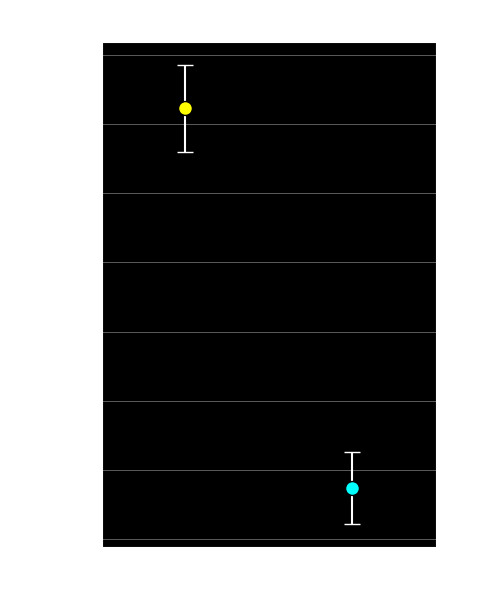

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# --- Load withinrows spacing ---
withinrows_df = pd.read_csv("W:\\Users\\Daphne\\Analysis\\predator-prey-dynamics-DL_particle_tracking\\comparison_mean_bb_distance_WT.csv")
withinrows_df = withinrows_df[withinrows_df['Group'].isin(['Singlets', 'Doublets'])]
withinrows_df.rename(columns={'Value': 'withinrows_Spacing_um'}, inplace=True)

# --- Load betweenrows spacing ---
betweenrows_df = df[['Type', 'FFT_Spacing_um']].rename(columns={
    'Type': 'Group',
    'FFT_Spacing_um': 'betweenrows_Spacing_um'
})

# --- Compute density stats ---
def compute_density(group):
    v_vals = betweenrows_df[betweenrows_df['Group'] == group]['betweenrows_Spacing_um']
    h_vals = withinrows_df[withinrows_df['Group'] == group]['withinrows_Spacing_um']
    
    mu_v = v_vals.mean()
    mu_h = h_vals.mean()
    sem_v = v_vals.sem()
    sem_h = h_vals.sem()

    density = 1 / (mu_v * mu_h)
    if group == 'Doublets':
        density *= 2

    # Propagate relative error
    rel_error_v = sem_v / mu_v
    rel_error_h = sem_h / mu_h
    sem_density = density * np.sqrt(rel_error_v**2 + rel_error_h**2)

    return {
        'Group': group,
        'Density_cells_per_um2': density,
        'Density_SEM': sem_density
    }

# Compute in order: Doublets first
stats_list = [
    compute_density('Doublets'),
    compute_density('Singlets')
]
stats_df = pd.DataFrame(stats_list)

# --- Plotting ---
plt.figure(figsize=(5, 6))  # Narrower width
plt.gca().set_facecolor('black')

# Colors and positions
color_map = {'Doublets': 'yellow', 'Singlets': 'cyan'}
x_positions = {'Doublets': 0.25, 'Singlets': 0.75}

# Plot each point
for _, row in stats_df.iterrows():
    x = x_positions[row['Group']]
    plt.errorbar(
        x=x,
        y=row['Density_cells_per_um2'],
        yerr=row['Density_SEM'],
        fmt='o',
        color='black',
        markersize=10,
        markerfacecolor=color_map[row['Group']],
        ecolor='white',
        capsize=6
    )

# Style
plt.xticks(ticks=[0, 1], labels=['Doublets', 'Singlets'], color='white', size=18)
plt.yticks(color='white', size=18)
plt.ylabel('Density [cilia/µm²]', fontsize=22, color='white')
plt.xlabel(None)
plt.title('Cilia Density (Mean ± SEM)', fontsize=24, color='white')
plt.grid(True, axis='y', color='white', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Save
file_path = 'W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Maximum projections\\ROIs for analysis\\output\\' 
plt.savefig(os.path.join(file_path, 'cell_density.svg'), format='svg')
plt.savefig(os.path.join(file_path, 'cell_density.png'), dpi=300)
plt.show()
plt.close()


C:\Users\laan\AppData\Local\Temp\ipykernel_27656\2503173123.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


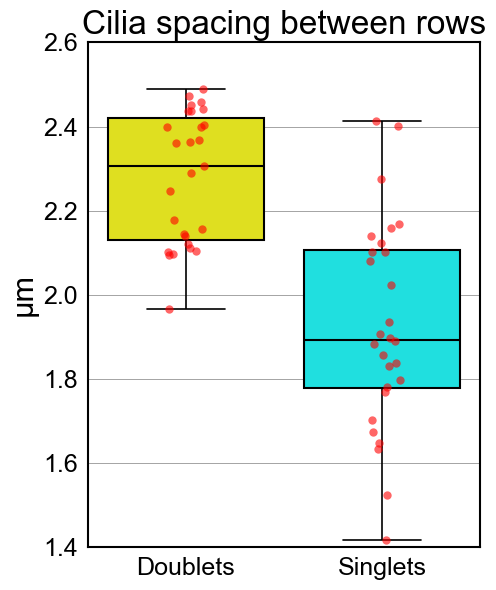

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Load CSV ---
file_path = 'W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Maximum projections\\ROIs for analysis\\output\\'
df = pd.read_csv(file_path + 'spacing_results.csv')

# --- Categorize rows as singlets or doublets ---
def categorize(filename):
    if 'doublets' in filename.lower():
        return 'Doublets'
    elif 'singlets' in filename.lower():
        return 'Singlets'
    else:
        return 'Unknown'

df['Type'] = df['Filename'].apply(categorize)
df = df[df['Type'].isin(['Doublets', 'Singlets'])]

# --- Convert spacing to non-expanded values ---
expansion_factor = 4.23
df['FFT_Spacing_um'] = df['FFT_Spacing_um'] / expansion_factor

# --- Custom grayscale palette ---
palette = {'Doublets': 'yellow', 'Singlets': 'cyan'}

# Common boxplot styles (black instead of white)
boxprops = dict(edgecolor='black', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.2)
capprops = dict(color='black', linewidth=1.2)
medianprops = dict(color='black', linewidth=1.5)

# --- Create plot ---
plt.figure(figsize=(5, 6), facecolor='white')
ax = plt.subplot(1, 1, 1, facecolor='white')

sns.boxplot(
    data=df,
    x='Type',
    y='FFT_Spacing_um',
    palette=palette,
    showfliers=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    linewidth=1.5
)

sns.stripplot(
    data=df,
    x='Type',
    y='FFT_Spacing_um',
    dodge=True,
    color='red',  # dark grey instead of red
    alpha=0.6,
    size=6,
    jitter=True
)

# White background, black text
plt.gca().set_facecolor('white')
plt.title('Cilia spacing between rows', fontsize=24, color='black')
plt.ylabel('µm', fontsize=22, color='black')
plt.xlabel(None)
plt.xticks(color='black', size=18)
plt.yticks(color='black', size=18)
plt.ylim(1.4, 2.6)
plt.grid(True, axis='y', color='black', linewidth=0.5, alpha=0.5)

# Black edge around plot
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(os.path.join(file_path, 'fft_spacing_singlets_vs_doublets_BW.svg'), format='svg', facecolor='white')
plt.savefig(os.path.join(file_path, 'fft_spacing_singlets_vs_doublets_BW.png'), dpi=300, facecolor='white')
plt.show()
plt.close()


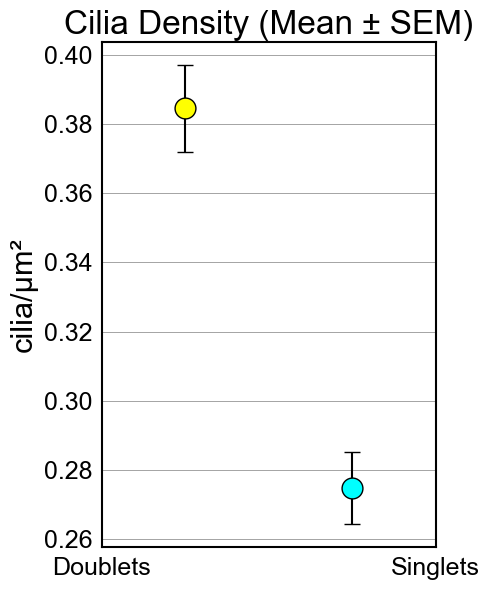

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Load withinrows spacing ---
withinrows_df = pd.read_csv("W:\\Users\\Daphne\\Analysis\\predator-prey-dynamics-DL_particle_tracking\\comparison_mean_bb_distance_WT.csv")
withinrows_df = withinrows_df[withinrows_df['Group'].isin(['Singlets', 'Doublets'])]
withinrows_df.rename(columns={'Value': 'withinrows_Spacing_um'}, inplace=True)

# --- Load betweenrows spacing ---
betweenrows_df = df[['Type', 'FFT_Spacing_um']].rename(columns={
    'Type': 'Group',
    'FFT_Spacing_um': 'betweenrows_Spacing_um'
})

# --- Compute density stats ---
def compute_density(group):
    v_vals = betweenrows_df[betweenrows_df['Group'] == group]['betweenrows_Spacing_um']
    h_vals = withinrows_df[withinrows_df['Group'] == group]['withinrows_Spacing_um']

    mu_v = v_vals.mean()
    mu_h = h_vals.mean()
    sem_v = v_vals.sem()
    sem_h = h_vals.sem()

    density = 1 / (mu_v * mu_h)
    if group == 'Doublets':
        density *= 2

    rel_error_v = sem_v / mu_v
    rel_error_h = sem_h / mu_h
    sem_density = density * np.sqrt(rel_error_v**2 + rel_error_h**2)

    return {'Group': group, 'Density_cells_per_um2': density, 'Density_SEM': sem_density}

stats_df = pd.DataFrame([compute_density('Doublets'), compute_density('Singlets')])

# --- Plotting ---
plt.figure(figsize=(5, 6), facecolor='white')
ax = plt.subplot(1, 1, 1, facecolor='white')

# Grayscale mapping
color_map = {'Doublets': 'yellow', 'Singlets': 'cyan'}
x_positions = {'Doublets': 0.25, 'Singlets': 0.75}

# Plot each point
for _, row in stats_df.iterrows():
    x = x_positions[row['Group']]
    plt.errorbar(
        x=x,
        y=row['Density_cells_per_um2'],
        yerr=row['Density_SEM'],
        fmt='o',
        color='black',  # black edges
        markersize=15,
        markerfacecolor=color_map[row['Group']],  # grey fills
        ecolor='black',
        capsize=6
    )

# Labels and styling (black instead of white)
plt.xticks(ticks=[0, 1], labels=['Doublets', 'Singlets'], color='black', size=18)
plt.yticks(color='black', size=18)
plt.ylabel('cilia/µm²', fontsize=22, color='black')
plt.xlabel(None)
plt.title('Cilia Density (Mean ± SEM)', fontsize=24, color='black')
plt.grid(True, axis='y', color='black', linewidth=0.5, alpha=0.5)

# Black edge around plot
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

plt.tight_layout()
file_path = 'W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Maximum projections\\ROIs for analysis\\output\\'
plt.savefig(os.path.join(file_path, 'cell_density_BW.svg'), format='svg', facecolor='white')
plt.savefig(os.path.join(file_path, 'cell_density_BW.png'), dpi=300, facecolor='white')
plt.show()
plt.close()
